In [1]:
# Import required libraries/packages.

import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
from prettytable import PrettyTable
from tqdm.notebook import tqdm

In [2]:
# Hyper parameter variables. 

batch = 100
learning_rate = 0.01
epochs = 25
device = 'cuda'

In [3]:
# Define dataset transforms. Convert to tensor then standardize tensors. 
# Create training and testing datasets, then dataloaders. 

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True, pin_memory=True)

In [4]:
# Construct convolutional neural network model from Torch base class nn.Module. 

class CNN(nn.Module):
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.fc1 = nn.Linear(16*4*4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def flatten(self, x):
        return x.view(x.size()[0], -1)

    def forward(self, x): 
        x = self.dropout(self.pool(self.relu(self.conv1(x))))
        x = self.dropout(self.pool(self.relu(self.conv2(x))))
        x = self.dropout(self.pool(self.relu(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)

In [5]:
# Initialize model, define loss function and optimizer. 

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [6]:
# Carry out training loop, displaying loss after each epoch. 

losses = []
for epoch in tqdm(range(epochs), leave=False): 
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.2f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Loss: 1104.54
Epoch 2/25, Loss: 874.48
Epoch 3/25, Loss: 743.45
Epoch 4/25, Loss: 680.68
Epoch 5/25, Loss: 625.09
Epoch 6/25, Loss: 587.84
Epoch 7/25, Loss: 556.40
Epoch 8/25, Loss: 536.57
Epoch 9/25, Loss: 517.77
Epoch 10/25, Loss: 503.78
Epoch 11/25, Loss: 492.71
Epoch 12/25, Loss: 480.93
Epoch 13/25, Loss: 472.23
Epoch 14/25, Loss: 465.87
Epoch 15/25, Loss: 456.60
Epoch 16/25, Loss: 449.70
Epoch 17/25, Loss: 443.85
Epoch 18/25, Loss: 439.26
Epoch 19/25, Loss: 434.36
Epoch 20/25, Loss: 429.08
Epoch 21/25, Loss: 427.10
Epoch 22/25, Loss: 424.76
Epoch 23/25, Loss: 419.59
Epoch 24/25, Loss: 416.93
Epoch 25/25, Loss: 413.48


In [7]:
# Set model to evaluation mode, then test with testing dataset. 
# Calculate accuracy and generate confusion matrix. 

model.eval()
all_preds = []
all_labels = []
with torch.no_grad(): 
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

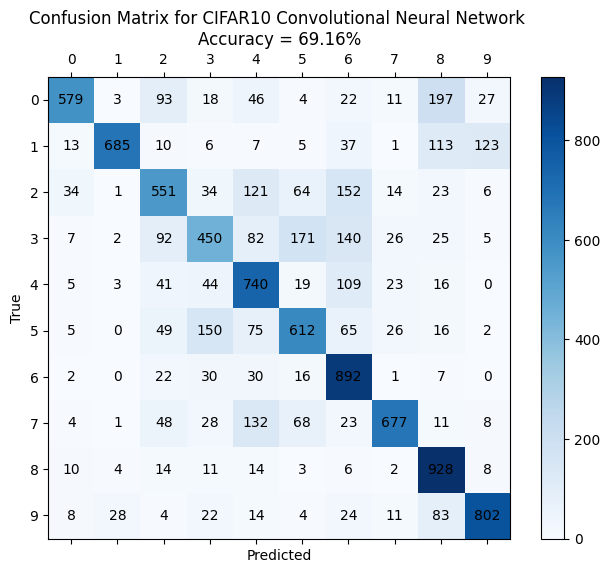

In [8]:
# Create matplotlib figure and fill in features for confusion matrix. 

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for CIFAR10 Convolutional Neural Network \nAccuracy = {100*accuracy:.2f}%')
for i in range(10):
    for j in range(10):
        ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

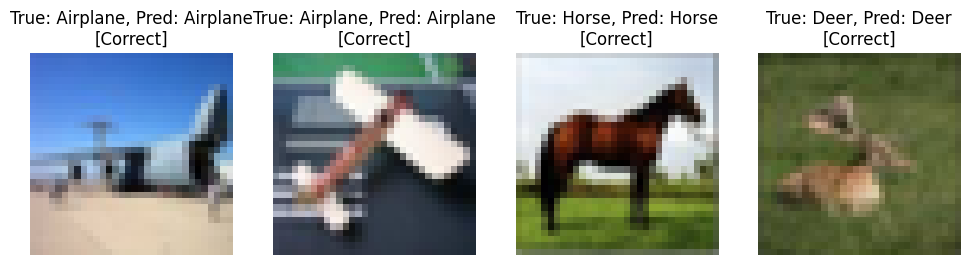

In [9]:
#  Visualize four sample predictions. 
#  Display target and predicted labels. 

def visualize_samples():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    fig, axes = plt.subplots(1, 4, figsize=(12,3))

    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    for i in range(4):
        image_rgb = images[i].cpu().permute(1, 2, 0)  #  (C, H, W) -> (H, W, C)
        image_rgb = 0.5 * (image_rgb + 1)
        axes[i].imshow(image_rgb)
        if labels[i].item() == preds[i].item(): 
            axes[i].set_title(f"True: {classes[labels[i].item()]}, Pred: {classes[preds[i].item()]}\n[Correct]")
        else: 
            axes[i].set_title(f"True: {classes[labels[i].item()]}, Pred: {classes[preds[i].item()]}\n[Not correct]")
        axes[i].axis('off')

visualize_samples()

In [10]:
# Generate model summary, showing all layers and parameters. 

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    432     |
|  conv1.bias  |     16     |
| conv2.weight |    4608    |
|  conv2.bias  |     32     |
| conv3.weight |    4608    |
|  conv3.bias  |     16     |
|  fc1.weight  |   25600    |
|   fc1.bias   |    100     |
|  fc2.weight  |    5000    |
|   fc2.bias   |     50     |
|  fc3.weight  |    500     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 40972
